# **Environment Setup**

In [1]:
!pip install wordcloud

# Data Pre-processing

In [2]:
# In case you get an import error, run again notebook cell number 3, 
# to install again miniconda and RAPIDS dependencies. If the problem persists,
# Go to Runtime -> Reset all runtimes and then run again the noebook cells (two 
# times the one for installing miniconda and RAPIDS dependencies)
import xgboost as xgb
import numpy as np
from sklearn.metrics import accuracy_score
import pandas as pd

In [2]:
#from google.colab import drive
#drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
movie_df_cudf_pd = pd.read_csv('data/IMDb movies.csv') 
#movie_df_cudf_pd=movie_df_cudf.to_pandas()
movie_df_cudf_pd.head()

C:\Users\QiZheng\anaconda3\envs\PythonData\lib\site-packages\IPython\core\interactiveshell.py:3146: DtypeWarning: Columns (3) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


,imdb_title_id,title,original_title,year,date_published,genre,duration,country,language,director,...,actors,description,avg_vote,votes,budget,usa_gross_income,worlwide_gross_income,metascore,reviews_from_users,reviews_from_critics
0,tt0000009,Miss Jerry,Miss Jerry,1894,1894-10-09,Romance,45,USA,None,Alexander Black,...,"Blanche Bayliss, William Courtenay, Chauncey D...",The adventures of a female reporter in the 1890s.,5.9,154,NaN,NaN,NaN,NaN,1.0,2.0
1,tt0000574,The Story of the Kelly Gang,The Story of the Kelly Gang,1906,1906-12-26,"Biography, Crime, Drama",70,Australia,None,Charles Tait,...,"Elizabeth Tait, John Tait, Norman Campbell, Be...",True story of notorious Australian outlaw Ned ...,6.1,589,$ 2250,NaN,NaN,NaN,7.0,7.0
2,tt0001892,Den sorte drøm,Den sorte drøm,1911,1911-08-19,Drama,53,"Germany, Denmark",NaN,Urban Gad,...,"Asta Nielsen, Valdemar Psilander, Gunnar Helse...",Two men of high rank are both wooing the beaut...,5.8,188,NaN,NaN,NaN,NaN,5.0,2.0
3,tt0002101,Cleopatra,Cleopatra,1912,1912-11-13,"Drama, History",100,USA,English,Charles L. Gaskill,...,"Helen Gardner, Pearl Sindelar, Miss Fielding, ...",The fabled queen of Egypt's affair with Roman ...,5.2,446,$ 45000,NaN,NaN,NaN,25.0,3.0
4,tt0002130,L'Inferno,L'Inferno,1911,1911-03-06,"Adventure, Drama, Fantasy",68,Italy,Italian,"Francesco Bertolini, Adolfo Padovan",...,"Salvatore Papa, Arturo Pirovano, Giuseppe de L...",Loosely adapted from Dante's Divine Comedy and...,7.0,2237,NaN,NaN,NaN,NaN,31.0,14.0


In [4]:
movie_df_cudf_pd.dtypes

imdb_title_id             object
title                     object
original_title            object
year                      object
date_published            object
genre                     object
duration                   int64
country                   object
language                  object
director                  object
writer                    object
production_company        object
actors                    object
description               object
avg_vote                 float64
votes                      int64
budget                    object
usa_gross_income          object
worlwide_gross_income     object
metascore                float64
reviews_from_users       float64
reviews_from_critics     float64
dtype: object

In [5]:
reduced_df = movie_df_cudf_pd[['original_title', 'year', 'date_published','language',
       'genre', 'duration', 'country', 'director', 'writer',
       'production_company', 'actors', 'avg_vote', 'votes',
       'budget', 'worlwide_gross_income']]

reduced_df

,original_title,year,date_published,language,genre,duration,country,director,writer,production_company,actors,avg_vote,votes,budget,worlwide_gross_income
0,Miss Jerry,1894,1894-10-09,None,Romance,45,USA,Alexander Black,Alexander Black,Alexander Black Photoplays,"Blanche Bayliss, William Courtenay, Chauncey D...",5.9,154,NaN,NaN
1,The Story of the Kelly Gang,1906,1906-12-26,None,"Biography, Crime, Drama",70,Australia,Charles Tait,Charles Tait,J. and N. Tait,"Elizabeth Tait, John Tait, Norman Campbell, Be...",6.1,589,$ 2250,NaN
2,Den sorte drøm,1911,1911-08-19,NaN,Drama,53,"Germany, Denmark",Urban Gad,"Urban Gad, Gebhard Schätzler-Perasini",Fotorama,"Asta Nielsen, Valdemar Psilander, Gunnar Helse...",5.8,188,NaN,NaN
3,Cleopatra,1912,1912-11-13,English,"Drama, History",100,USA,Charles L. Gaskill,Victorien Sardou,Helen Gardner Picture Players,"Helen Gardner, Pearl Sindelar, Miss Fielding, ...",5.2,446,$ 45000,NaN
4,L'Inferno,1911,1911-03-06,Italian,"Adventure, Drama, Fantasy",68,Italy,"Francesco Bertolini, Adolfo Padovan",Dante Alighieri,Milano Film,"Salvatore Papa, Arturo Pirovano, Giuseppe de L...",7.0,2237,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
85850,Le lion,2020,2020-01-29,French,Comedy,95,"France, Belgium",Ludovic Colbeau-Justin,"Alexandre Coquelle, Matthieu Le Naour",Monkey Pack Films,"Dany Boon, Philippe Katerine, Anne Serra, Samu...",5.3,398,NaN,$ 3507171
85851,De Beentjes van Sint-Hildegard,2020,2020-02-13,"German, Dutch","Comedy, Drama",103,Netherlands,Johan Nijenhuis,"Radek Bajgar, Herman Finkers",Johan Nijenhuis & Co,"Herman Finkers, Johanna ter Steege, Leonie ter...",7.7,724,NaN,$ 7299062
85852,Padmavyuhathile Abhimanyu,2019,2019-03-08,Malayalam,Drama,130,India,Vineesh Aaradya,"Vineesh Aaradya, Vineesh Aaradya",RMCC Productions,"Anoop Chandran, Indrans, Sona Nair, Simon Brit...",7.9,265,NaN,NaN
85853,Sokagin Çocuklari,2019,2019-03-15,Turkish,"Drama, Family",98,Turkey,Ahmet Faik Akinci,"Ahmet Faik Akinci, Kasim Uçkan",Gizem Ajans,"Ahmet Faik Akinci, Belma Mamati, Metin Keçeci,...",6.4,194,NaN,$ 2833


In [6]:
len(reduced_df)

85855

In [7]:
test_clean_df = reduced_df.dropna()

In [8]:
usa_df=test_clean_df[test_clean_df["budget"].str.startswith("$")]
usa_df=usa_df[test_clean_df["worlwide_gross_income"].str.startswith("$")]
usa_df['budget'] = usa_df['budget'].str.replace('$','')
usa_df['worlwide_gross_income'] = usa_df['worlwide_gross_income'].str.replace('$','')
usa_df['budget'] = usa_df['budget'].astype(np.int64)
usa_df['worlwide_gross_income'] = usa_df['worlwide_gross_income'].astype(np.int64)
usa_df['year'] = usa_df['year'].astype(np.int64)
usa_df

<ipython-input-8-ec3a4406aa94>:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  usa_df=usa_df[test_clean_df["worlwide_gross_income"].str.startswith("$")]


,original_title,year,date_published,language,genre,duration,country,director,writer,production_company,actors,avg_vote,votes,budget,worlwide_gross_income
165,Das Cabinet des Dr. Caligari,1920,1920-02-27,German,"Fantasy, Horror, Mystery",76,Germany,Robert Wiene,"Carl Mayer, Hans Janowitz",Decla-Bioscop AG,"Werner Krauss, Conrad Veidt, Friedrich Feher, ...",8.1,55601,18000,8811
245,The Four Horsemen of the Apocalypse,1921,1923-04-16,None,"Drama, Romance, War",150,USA,Rex Ingram,"Vicente Blasco Ibáñez, June Mathis",Metro Pictures Corporation,"Pomeroy Cannon, Josef Swickard, Bridgetta Clar...",7.2,3058,800000,9183673
251,The Kid,1921,1923-11-26,"English, None","Comedy, Drama, Family",68,USA,Charles Chaplin,Charles Chaplin,Charles Chaplin Productions,"Carl Miller, Edna Purviance, Jackie Coogan, Ch...",8.3,109038,250000,26916
348,A Woman of Paris: A Drama of Fate,1923,1927-06-06,"None, English","Drama, Romance",82,USA,Charles Chaplin,Charles Chaplin,Charles Chaplin Productions,"Edna Purviance, Clarence Geldart, Carl Miller,...",7.0,4735,351000,11233
415,The Gold Rush,1925,1925-10-23,"English, None","Adventure, Comedy, Drama",95,USA,Charles Chaplin,Charles Chaplin,Charles Chaplin Productions,"Charles Chaplin, Mack Swain, Tom Murray, Henry...",8.2,97480,923000,26916
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
85477,Plane Tree,2018,2019-04-12,Turkish,Drama,99,Turkey,Mustafa Karadeniz,"Necip Güleçer, Mustafa Karadeniz",Cinar Film Yapim,"Sezgin Cengiz, Silan Düzdaban, Yunus Emre Çeli...",6.8,168,200000,4183
85530,Doblemente Embarazada,2019,2019-12-20,Spanish,Comedy,98,Mexico,Koko Stambuk,"Diego Ayala, Koko Stambuk",SDB Films,"Roberta Burns, Gustavo Egelhaaf, Luis Felipe C...",4.4,197,950000,965558
85592,Quezon's Game,2018,2019-05-29,English,"Drama, History",127,Philippines,Matthew E. Rosen,"Janice Y. Perez, Dean Rosen",Star Cinema,"Raymond Bagatsing, Rachel Alejandro, Kate Alej...",7.5,117,500000,5986
85740,I Still Believe,2020,2020-03-19,English,"Biography, Drama, Music",116,USA,"Andrew Erwin, Jon Erwin","Jeremy Camp, Jon Erwin",Kevin Downes Productions,"K.J. Apa, Britt Robertson, Nathan Parsons, Gar...",6.5,6196,12000000,13681524


In [9]:
usa_df.dtypes

original_title            object
year                       int64
date_published            object
language                  object
genre                     object
duration                   int64
country                   object
director                  object
writer                    object
production_company        object
actors                    object
avg_vote                 float64
votes                      int64
budget                     int64
worlwide_gross_income      int64
dtype: object

In [10]:
def extract_day(film_date):
    try:
        datetime_object = datetime.strptime(film_date, '%Y-%m-%d')
        film_day = datetime_object.timetuple().tm_yday
        return film_day
    except:
        return 0

from datetime import datetime
#usa_df['month']=usa_df['date_published'].apply(lambda x: datetime.strptime(x, '%Y-%m-%d').timetuple().tm_yday)
usa_df['day']=usa_df['date_published'].apply(lambda x: extract_day(x))
usa_df=usa_df[usa_df['day']>0]
usa_df

,original_title,year,date_published,language,genre,duration,country,director,writer,production_company,actors,avg_vote,votes,budget,worlwide_gross_income,day
165,Das Cabinet des Dr. Caligari,1920,1920-02-27,German,"Fantasy, Horror, Mystery",76,Germany,Robert Wiene,"Carl Mayer, Hans Janowitz",Decla-Bioscop AG,"Werner Krauss, Conrad Veidt, Friedrich Feher, ...",8.1,55601,18000,8811,58
245,The Four Horsemen of the Apocalypse,1921,1923-04-16,None,"Drama, Romance, War",150,USA,Rex Ingram,"Vicente Blasco Ibáñez, June Mathis",Metro Pictures Corporation,"Pomeroy Cannon, Josef Swickard, Bridgetta Clar...",7.2,3058,800000,9183673,106
251,The Kid,1921,1923-11-26,"English, None","Comedy, Drama, Family",68,USA,Charles Chaplin,Charles Chaplin,Charles Chaplin Productions,"Carl Miller, Edna Purviance, Jackie Coogan, Ch...",8.3,109038,250000,26916,330
348,A Woman of Paris: A Drama of Fate,1923,1927-06-06,"None, English","Drama, Romance",82,USA,Charles Chaplin,Charles Chaplin,Charles Chaplin Productions,"Edna Purviance, Clarence Geldart, Carl Miller,...",7.0,4735,351000,11233,157
415,The Gold Rush,1925,1925-10-23,"English, None","Adventure, Comedy, Drama",95,USA,Charles Chaplin,Charles Chaplin,Charles Chaplin Productions,"Charles Chaplin, Mack Swain, Tom Murray, Henry...",8.2,97480,923000,26916,296
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
85477,Plane Tree,2018,2019-04-12,Turkish,Drama,99,Turkey,Mustafa Karadeniz,"Necip Güleçer, Mustafa Karadeniz",Cinar Film Yapim,"Sezgin Cengiz, Silan Düzdaban, Yunus Emre Çeli...",6.8,168,200000,4183,102
85530,Doblemente Embarazada,2019,2019-12-20,Spanish,Comedy,98,Mexico,Koko Stambuk,"Diego Ayala, Koko Stambuk",SDB Films,"Roberta Burns, Gustavo Egelhaaf, Luis Felipe C...",4.4,197,950000,965558,354
85592,Quezon's Game,2018,2019-05-29,English,"Drama, History",127,Philippines,Matthew E. Rosen,"Janice Y. Perez, Dean Rosen",Star Cinema,"Raymond Bagatsing, Rachel Alejandro, Kate Alej...",7.5,117,500000,5986,149
85740,I Still Believe,2020,2020-03-19,English,"Biography, Drama, Music",116,USA,"Andrew Erwin, Jon Erwin","Jeremy Camp, Jon Erwin",Kevin Downes Productions,"K.J. Apa, Britt Robertson, Nathan Parsons, Gar...",6.5,6196,12000000,13681524,79


In [11]:
usa_df=usa_df.drop(['date_published'],axis=1)

In [12]:
from collections import Counter

In [13]:
list_of_languages = list(usa_df['language'].apply(lambda x:  [i for i in x.split(', ')]).values)
top_languages = [x[0] for x in Counter([i for j in list_of_languages for i in j]).most_common()[:30]]

In [14]:
list_of_genres = list(usa_df['genre'].apply(lambda x:  [i for i in x.split(', ')]).values)
all_genres = [x[0] for x in Counter([i for j in list_of_genres for i in j]).most_common()]

In [15]:
list_of_countries = list(usa_df['country'].apply(lambda x:  [i for i in x.split(', ')]).values)
top_countries = [x[0] for x in Counter([i for j in list_of_countries for i in j]).most_common()[:30]]

In [16]:
list_of_actors = list(usa_df['actors'].apply(lambda x:  [i for i in x.split(', ')]).values)
rd_list_of_actors=[x[0:5] for x in list_of_actors]
all_actors = Counter([i for j in rd_list_of_actors for i in j]).most_common()
top_actors = [x[0] for x in all_actors if x[1]>10]

In [17]:
list_of_directors = list(usa_df['director'].apply(lambda x:  [i for i in x.split(', ')]).values)
all_directors = Counter([i for j in list_of_directors for i in j]).most_common()
top_directors = [x[0] for x in all_directors if x[1]>=5]

In [18]:
list_of_writers = list(usa_df['writer'].apply(lambda x:  [i for i in x.split(', ')]).values)
all_writers = Counter([i for j in list_of_writers for i in j]).most_common()
top_writers = [x[0] for x in all_writers if x[1]>=5]

In [19]:
list_of_companies = list(usa_df['production_company'].apply(lambda x:  [i for i in x.split(', ')]).values)
all_companies = Counter([i for j in list_of_companies for i in j]).most_common()
top_companies = [x[0] for x in all_companies if x[1]>=5]

In [20]:
for language in top_languages:
  usa_df['language_' + language] = usa_df['language'].apply(lambda x: 1 if language in x.split(', ') else 0)

In [21]:
for genre in all_genres:
  usa_df['genre_' + genre] = usa_df['genre'].apply(lambda x: 1 if genre in x.split(', ') else 0)

In [22]:
for country in top_countries:
  usa_df['country_' + country] = usa_df['country'].apply(lambda x: 1 if country in x.split(', ') else 0)

In [23]:
for director in top_directors:
  usa_df['director_' + director] = usa_df['director'].apply(lambda x: 1 if director in x.split(', ') else 0)

In [24]:
for writer in top_writers:
  usa_df['writer_' + writer] = usa_df['writer'].apply(lambda x: 1 if writer in x.split(', ') else 0)

In [25]:
for company in top_companies:
  usa_df['company_' + company] = usa_df['production_company'].apply(lambda x: 1 if company in x.split(', ') else 0)

In [26]:
for actor in top_actors:
  usa_df['actor_' + actor] = usa_df['actors'].apply(lambda x: 1 if actor in x.split(', ')[0:5] else 0)

In [27]:
usa_df=usa_df.reset_index(drop=True)

In [28]:
sample_df=usa_df.select_dtypes(include=['int64','float64'])

In [29]:
sample_df.shape

(8870, 1872)

In [30]:
sample_df.head()

,year,duration,avg_vote,votes,budget,worlwide_gross_income,day,language_English,language_Spanish,language_French,...,actor_Matthew Goode,actor_Edgar Ramírez,actor_Tyler Perry,actor_Sebastian Stan,actor_Rebecca Hall,actor_Cam Gigandet,actor_Miles Teller,actor_Scott Adkins,actor_Octavia Spencer,actor_Dave Bautista
0,1920,76,8.1,55601,18000,8811,58,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1921,150,7.2,3058,800000,9183673,106,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1921,68,8.3,109038,250000,26916,330,1,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1923,82,7.0,4735,351000,11233,157,1,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1925,95,8.2,97480,923000,26916,296,1,0,0,...,0,0,0,0,0,0,0,0,0,0


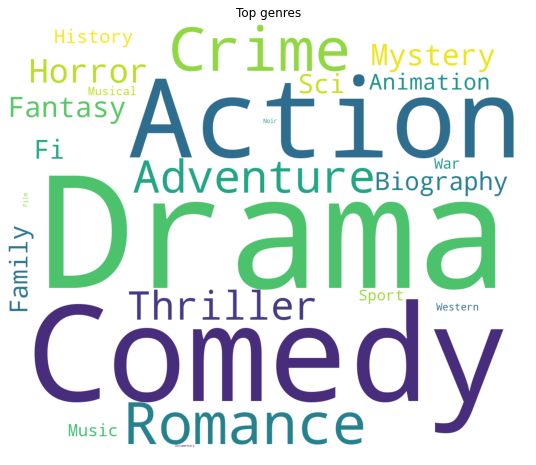

In [32]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud
plt.figure(figsize = (12, 8))
text = ' '.join([i for j in list_of_genres for i in j])
wordcloud = WordCloud(max_font_size=None, background_color='white', collocations=False,
                      width=1200, height=1000).generate(text)
plt.imshow(wordcloud)
plt.title('Top genres')
plt.axis("off")
plt.show()

# Model test

In [33]:
sample_df.head()

,year,duration,avg_vote,votes,budget,worlwide_gross_income,day,language_English,language_Spanish,language_French,...,actor_Matthew Goode,actor_Edgar Ramírez,actor_Tyler Perry,actor_Sebastian Stan,actor_Rebecca Hall,actor_Cam Gigandet,actor_Miles Teller,actor_Scott Adkins,actor_Octavia Spencer,actor_Dave Bautista
0,1920,76,8.1,55601,18000,8811,58,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1921,150,7.2,3058,800000,9183673,106,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1921,68,8.3,109038,250000,26916,330,1,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1923,82,7.0,4735,351000,11233,157,1,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1925,95,8.2,97480,923000,26916,296,1,0,0,...,0,0,0,0,0,0,0,0,0,0


In [266]:
X = sample_df.drop(["avg_vote","worlwide_gross_income"], axis=1)

In [267]:
X.head()

,year,duration,votes,budget,day,language_English,language_Spanish,language_French,language_Russian,language_German,...,actor_Matthew Goode,actor_Edgar Ramírez,actor_Tyler Perry,actor_Sebastian Stan,actor_Rebecca Hall,actor_Cam Gigandet,actor_Miles Teller,actor_Scott Adkins,actor_Octavia Spencer,actor_Dave Bautista
0,1920,76,55601,18000,58,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
1,1921,150,3058,800000,106,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1921,68,109038,250000,330,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1923,82,4735,351000,157,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1925,95,97480,923000,296,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [268]:
vote_y=sample_df["avg_vote"]
nvote_y=sample_df["votes"]
revenue_y=sample_df["worlwide_gross_income"]

In [279]:
from sklearn.model_selection import train_test_split
X_train, X_test, revenue_y_train, revenue_y_test = train_test_split(X, revenue_y, test_size=0.2)

In [280]:
X_train.head()

,year,duration,votes,budget,day,language_English,language_Spanish,language_French,language_Russian,language_German,...,actor_Matthew Goode,actor_Edgar Ramírez,actor_Tyler Perry,actor_Sebastian Stan,actor_Rebecca Hall,actor_Cam Gigandet,actor_Miles Teller,actor_Scott Adkins,actor_Octavia Spencer,actor_Dave Bautista
5959,2020,76,823,1000000,58,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
5598,2008,113,94632,20000000,333,1,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
7912,2017,92,66035,10000000,304,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1994,1995,102,99916,2000000,111,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1206,1988,110,11420,15000000,238,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [281]:
from sklearn.preprocessing import MinMaxScaler
duration_scaler=MinMaxScaler().fit(X[["duration"]])
day_scaler=MinMaxScaler().fit(X[["day"]])

In [282]:
X_train_scaled=X_train
X_test_scaled=X_test
revenue_y_train_scaled=revenue_y_train
revenue_y_test_scaled=revenue_y_test

In [283]:
X_train_scaled["duration"]=duration_scaler.transform(X_train_scaled[["duration"]])
X_train_scaled["day"]=day_scaler.transform(X_train_scaled[["day"]])

X_test_scaled["duration"]=duration_scaler.transform(X_test_scaled[["duration"]])
X_test_scaled["day"]=day_scaler.transform(X_test_scaled[["day"]])

<ipython-input-283-0cf7ae00b4bf>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_scaled["duration"]=duration_scaler.transform(X_train_scaled[["duration"]])
<ipython-input-283-0cf7ae00b4bf>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_scaled["day"]=day_scaler.transform(X_train_scaled[["day"]])
<ipython-input-283-0cf7ae00b4bf>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cave

In [284]:
print('X_train dimensions: ', X_train_scaled.shape, 'y_train: ', revenue_y_train_scaled.shape)
print('X_test dimensions:', X_test_scaled.shape, 'y_validation: ', revenue_y_test_scaled.shape)

X_train dimensions:  (7096, 1870) y_train:  (7096,)
X_test dimensions: (1774, 1870) y_validation:  (1774,)


In [285]:
from xgboost import XGBRegressor
regressor = XGBRegressor(colsample_bytree= 0.6, gamma= 0.7, max_depth= 5, min_child_weight= 5,
                         subsample = 0.8, objective='reg:squarederror')
regressor.fit(X_train_scaled, revenue_y_train_scaled)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.6, gamma=0.7, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=5,
             min_child_weight=5, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=8, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=0.8,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [286]:
revenue_y_pred = regressor.predict(X_test_scaled)
from sklearn.metrics import r2_score
score = r2_score(revenue_y_test_scaled, revenue_y_pred)
print(score)

0.7575001636680863


In [287]:
select_features=[]
for col,score in zip(X_train.columns,regressor.feature_importances_):
  if score >0.00001:
    select_features.append(col)
    print(col,score)

year 0.007018216
duration 0.014386906
votes 0.020938901
budget 0.03167142
day 0.0031205772
language_English 0.0018313907
language_Spanish 0.0015460708
language_French 0.0015822848
language_Russian 0.0008911088
language_Italian 0.0028676032
language_Japanese 0.0020111285
language_Mandarin 0.0019234509
language_Latin 0.0022417246
language_Hebrew 0.0031562077
language_Ukrainian 0.0018340806
language_Swedish 0.0014309369
language_Thai 0.0018634199
language_American Sign Language 0.0005283019
language_Czech 0.0007001172
genre_Drama 0.004304567
genre_Comedy 0.003247279
genre_Action 0.025594506
genre_Crime 0.00270338
genre_Romance 0.0017081342
genre_Adventure 0.07748089
genre_Thriller 0.00022896443
genre_Horror 0.0024454852
genre_Mystery 0.0006058052
genre_Fantasy 0.0023970676
genre_Sci-Fi 0.0029494755
genre_Family 0.007547609
genre_Biography 0.0013489104
genre_Animation 0.03150911
genre_History 2.0513502e-05
genre_Music 0.0066126306
genre_War 0.00014104598
genre_Musical 0.018288467
country_U

In [288]:
len(select_features)

256

In [289]:
select_sample_df=sample_df[select_features]

In [290]:
select_sample_df

,year,duration,votes,budget,day,language_English,language_Spanish,language_French,language_Russian,language_Italian,...,actor_Jon Favreau,actor_Michelle Rodriguez,actor_Josh Hutcherson,actor_Peter Coyote,actor_Catherine O'Hara,actor_Dougray Scott,actor_Allison Janney,actor_Michael Sheen,actor_Vanessa Hudgens,actor_Dave Bautista
0,1920,76,55601,18000,58,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1921,150,3058,800000,106,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1921,68,109038,250000,330,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1923,82,4735,351000,157,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1925,95,97480,923000,296,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8865,2018,99,168,200000,102,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8866,2019,98,197,950000,354,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8867,2018,127,117,500000,149,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8868,2020,116,6196,12000000,79,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [291]:
X_selected = select_sample_df
X_selected_train, X_selected_test, revenue_y_train, revenue_y_test = train_test_split(X_selected, revenue_y, test_size = 0.2)

X_selected_train_scaled=X_selected_train
X_selected_test_scaled=X_selected_test
revenue_y_train_scaled=revenue_y_train
revenue_y_test_scaled=revenue_y_test

X_selected_train_scaled["duration"]=duration_scaler.transform(X_selected_train_scaled[["duration"]])
X_selected_train_scaled["day"]=day_scaler.transform(X_selected_train_scaled[["day"]])
X_selected_test_scaled["duration"]=duration_scaler.transform(X_selected_test_scaled[["duration"]])
X_selected_test_scaled["day"]=day_scaler.transform(X_selected_test_scaled[["day"]])

print('X_train dimensions: ', X_selected_train_scaled.shape, 'y_train: ', revenue_y_train_scaled.shape)
print('X_test dimensions:', X_selected_test_scaled.shape, 'y_validation: ', revenue_y_test_scaled.shape)

X_train dimensions:  (7096, 256) y_train:  (7096,)
X_test dimensions: (1774, 256) y_validation:  (1774,)


<ipython-input-291-7284f184b79c>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_selected_train_scaled["duration"]=duration_scaler.transform(X_selected_train_scaled[["duration"]])
<ipython-input-291-7284f184b79c>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_selected_train_scaled["day"]=day_scaler.transform(X_selected_train_scaled[["day"]])
<ipython-input-291-7284f184b79c>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_

In [293]:
regressor = XGBRegressor(colsample_bytree= 0.6, gamma= 0.7, max_depth= 5, min_child_weight= 5,
                         subsample = 0.8, objective='reg:squarederror')
regressor.fit(X_selected_train_scaled, revenue_y_train_scaled)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.6, gamma=0.7, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=5,
             min_child_weight=5, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=8, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=0.8,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [294]:
revenue_y_pred = regressor.predict(X_selected_test_scaled)
from sklearn.metrics import r2_score
score = r2_score(revenue_y_test_scaled, revenue_y_pred)
print(score)

0.7343541054485485


In [320]:
regressor = XGBRegressor(max_depth= 7, min_child_weight= 4, learning_rate=0.1,
                         n_estimators=500, colsample_bytree= 0.9, subsample = 0.7,
                         gamma= 0.7, objective='reg:squarederror')

In [324]:
gridparas = {
#    'max_depth': [3,5, 7],
#    'learning_rate': [0.06,0.1,0.3],
#    'n_estimators': [100,200, 500],
#    'min_child_weight': [2, 3, 4],
#    'max_delta_step': [0, 0.2, 0.6, 1, 2],
#    'subsample': [0.5,0.6,0.7],
#    'colsample_bytree': [0.8,0.9],
#    'reg_alpha': [0, 0.25, 0.5, 0.75, 1],
#    'reg_lambda': [0.2, 0.4, 0.6, 0.8, 1],
#    'gamma': [0.1, 0.3],
#    'scale_pos_weight': [0.2, 0.4, 0.6, 0.8, 1]
}

In [325]:
from sklearn.model_selection import GridSearchCV
gsearch = GridSearchCV(regressor, param_grid=gridparas,verbose=3, n_jobs=-1)
gsearch.fit(X_selected_train_scaled,revenue_y_train_scaled)

Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 out of  30 | elapsed:  3.0min remaining:   27.6s
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:  3.0min finished


GridSearchCV(estimator=XGBRegressor(base_score=None, booster=None,
                                    colsample_bylevel=None,
                                    colsample_bynode=None, colsample_bytree=0.6,
                                    gamma=0.7, gpu_id=None,
                                    importance_type='gain',
                                    interaction_constraints=None,
                                    learning_rate=0.1, max_delta_step=None,
                                    max_depth=7, min_child_weight=4,
                                    missing=nan, monotone_constraints=None,
                                    n_estimators=500, n_jobs=None,
                                    num_parallel_tree=None, random_state=None,
                                    reg_alpha=None, reg_lambda=None,
                                    scale_pos_weight=None, subsample=0.8,
                                    tree_method=None, validate_parameters=None,
                

In [326]:
print(gsearch.best_params_)
print(gsearch.best_score_)

{'colsample_bytree': 0.9, 'subsample': 0.7}
0.7847188830596538


In [327]:
regressor = XGBRegressor(max_depth= 7, min_child_weight= 4, learning_rate=0.1,
                         n_estimators=500, colsample_bytree= 0.9, subsample = 0.7,
                         gamma= 0.7, objective='reg:squarederror')
regressor.fit(X_selected_train_scaled, revenue_y_train_scaled)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.9, gamma=0.7, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.1, max_delta_step=0, max_depth=7,
             min_child_weight=4, missing=nan, monotone_constraints='()',
             n_estimators=500, n_jobs=8, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=0.7,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [328]:
revenue_y_pred = regressor.predict(X_selected_test_scaled)
from sklearn.metrics import r2_score
score = r2_score(revenue_y_test_scaled, revenue_y_pred)
print(score)

0.7620811695938658


In [329]:
import joblib
filename = 'xgboost_model.sav'
joblib.dump(regressor, filename)

['xgboost_model.sav']

In [330]:
regressor.save_model("xgboost_regressor.sav")

In [332]:
select_sample_df.to_csv("select_sample_df.csv",index=False)

In [ ]:
select_sample_df.to_csv("select_sample_df")